<a href="https://colab.research.google.com/github/joshcova/LLMs-for-social-scientists/blob/main/code/Intercoder_reliability_statistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A primer for the use of classifiers and large language models in social science research

In this document, we will showcase how to implement a coding pipeline which uses classifiers/LLMs in practice. Feel free to re-use and share!

Load the necessary libraries.

Note that if you have not installed these libraries this code will not work, you will first have to `pip install` the libraries in a terminal window.

In [ ]:
! pip install AugmentedSocialScientist
! pip install krippendorff

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
import krippendorff
import datetime
import seaborn as sns
from AugmentedSocialScientist.models import Bert


In [6]:
df_all = pd.read_csv("https://raw.githubusercontent.com/joshcova/LLMs-for-social-scientists/main/data/df_grouped_cbi_UK.csv")

## Inspecting the data

As for any data analysis exercise, let us begin by inspecting the data that we are working with.

We can do this by printing out the first few rows of the dataframe.

In [7]:
df_all.head()

,id,date_short,party,party_2,name,sents
0,1,6/29/1972,Labour Party,labour,Mr. Wilson,special drawing rights were a step in the righ...
1,2,2/29/1972,Labour Party,labour,Mr. Tam Dalyell,he raises the question of the accepting houses...
2,3,2/13/1973,Labour Party,labour,Mr. Tam Dalyell,that issue concerns the role of the bank of en...
3,4,3/12/1975,Labour Party,labour,Sir Brandon Rhys Williams,where does the european fund fit in? and do we...
4,5,2/25/1976,Conservative Party,conservative,Mr. Nelson,if i correctly judge the enormity of the words...


We can also tabulate the frequency by different groups. This will show us how frequently different parties discuss central bank independence

In [8]:
df_all.groupby("party_2")["id"].count()

,id
party_2,
Others,237
conservative,818
labour,902


Finally, let us examine the extent to which the salience of the topic has changed in time

In [9]:
# Pre-process the data to convert the year
df_all["date_short"] = pd.to_datetime(df_all["date_short"])

In [10]:
df_all["year"] = df_all["date_short"].dt.year

In [11]:
g1 = df_all.groupby(["year", "party_2"], as_index=False).count()

In [12]:
# Colour-code the data

custom_palette = {
    "labour": "red",
    "conservative": "blue",
    "Others": "yellow"
}

Text(0.5, 0, 'Years')

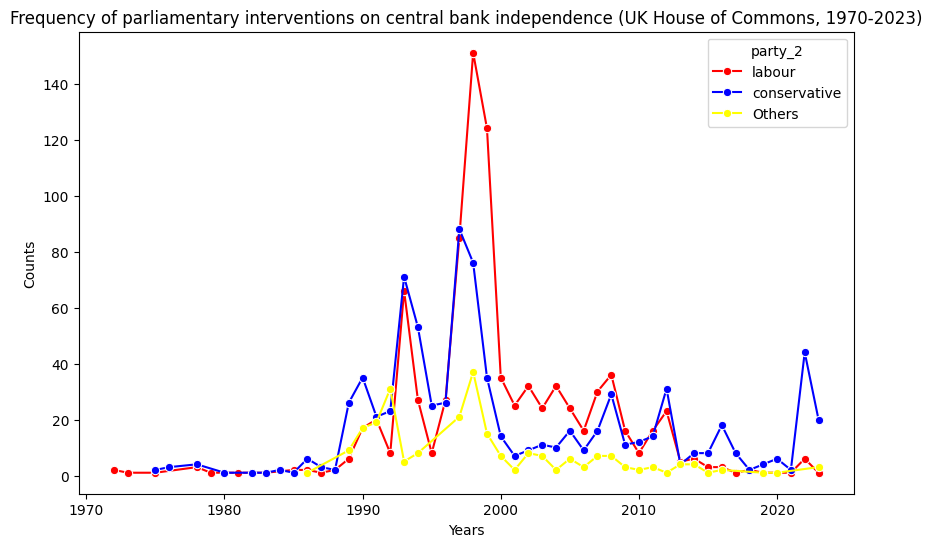

In [13]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=g1, x="year", y="sents", hue="party_2", marker="o", palette=custom_palette)

plt.title("Frequency of parliamentary interventions on central bank independence (UK House of Commons, 1970-2023)")
plt.ylabel("Counts")
plt.xlabel("Years")

## Inter-coder reliability

Now, that we have developed a better feeling for the data, let us use the tools that we have discussed in the paper to examine how discussions on central bank independence have changed in time.

To do this, 2 researchers have annotated a sample of 150 parliamentary interventions discussing central bank independence. This corresponds to 7.5% of the entire dataset. The researchers have divided parliamentary interventions on this topic into the following categories:

1. Pro-independence
2. Anti-independence
3. Unrelated

Before delving into automated classification techniques and NLP let us first examine the level of agreement between the two coders on the sample.

Importantly, the two coders have not seen each others' text classification. This is important as we want to ensure that coders label the texts *independently*.

In [14]:
df_cbi = pd.read_csv("https://raw.githubusercontent.com/joshcova/LLMs-for-social-scientists/main/data/uk_cbi_sample.csv")

In [15]:
df_cbi.groupby("results_1")["results_1"].count()

,results_1
results_1,
Anti-independence,10
Pro-independence,85
Unrelated,55


In [16]:
df_cbi.groupby("results_2")["results_2"].count()

,results_2
results_2,
Anti-independence,11
Pro-independence,83
Unrelated,56


We now focus only on one data frame with the results of the two coders side by side. This will allow us to quantify the levels of agreement

In [18]:
results = df_cbi[["results_1","results_2"]]

In [20]:
kappa = cohen_kappa_score(results["results_1"], results["results_2"])
print(f"Cohen's Kappa: {kappa:.2f}")

Cohen's Kappa: 0.94


In [21]:
categories = {category: idx for idx, category in enumerate(results.stack().unique())}
print(f"Category Mapping: {categories}")

df_encoded = results.replace(categories)

# Reformat data for Krippendorff's alpha
ratings = df_encoded.T.values  # Transpose to align with Krippendorff's format

Category Mapping: {'Pro-independence': 0, 'Unrelated': 1, 'Anti-independence': 2}


<ipython-input-21-7e675252d105>:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_encoded = results.replace(categories)


In [22]:
alpha = krippendorff.alpha(reliability_data=ratings, level_of_measurement='nominal')
print(alpha)

0.938997021259232


As one can see, the level of agreement between the two coders is quite high.

In a real-life research exercise, this might not be the case. In that case it is customary to go back to the drawing board and possibly revise the coding scheme.

In cases where the two coders disagreed with one another on the correct labeling of the text, they would discuss and reach an agreement. Ultimately, the objective is to have one and only one label per text.

However, for the purposes of this exercise let us just establish that the results of coder 1 ("results_1" column) can act as the ground truth.